In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
# import constants as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('C:/SynthFirm')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
year_of_analysis = ['2019', '2020']
# shipment_load_attr = 'tons_' + str(analysis_year)
# shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

In [2]:
plot_dir = 'plots_pandemic/'
input_dir = 'inputs_national/'
# output_dir = 'outputs_national/'
param_dir = 'SynthFirm_parameters/'
valid_dir = 'Validation/'

This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [3]:
#load FAF data
# print(c.cfs_distribution_file)
faf_data = read_csv(valid_dir + 'FAF5.6.1.csv', sep = ',')


#load parameters
sctg_group_lookup = read_csv(param_dir + 'SCTG_Groups_revised.csv', sep = ',')
mesozone_lookup = read_csv(input_dir + 'zonal_id_lookup_final.csv', sep = ',')
cfs_faf_lookup = read_csv('SynthFirm_parameters/' + 'CFS_FAF_LOOKUP.csv', sep = ',')

sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
print(sctg_names)

faf_data_domestic = faf_data.loc[faf_data['trade_type'] == 1] #select domestic shipment only

faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['mode_def'] != 'Other']

print(faf_data_domestic.columns)

['interm_food' 'bulk' 'mfr_goods' 'fuel_fert' 'other']
Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2021', 'tons_2022',
       'tons_2023', 'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040',
       'tons_2045', 'tons_2050', 'value_2017', 'value_2018', 'value_2019',
       'value_2020', 'value_2021', 'value_2022', 'value_2023', 'value_2025',
       'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050',
       'current_value_2018', 'current_value_2019', 'current_value_2020',
       'current_value_2021', 'current_value_2022', 'current_value_2023',
       'tmiles_2017', 'tmiles_2018', 'tmiles_2019', 'tmiles_2020',
       'tmiles_2021', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050', 'mode_def', 'SCTG_Code', 'SCTG_Group', 'SCTG_Name',
   

In [12]:
# aggregate faf data 
faf_production_by_sctg = None
faf_name_lookup = cfs_faf_lookup[['FAF', 'SHORTNAME']]

value_attrs = []
for year in year_of_analysis:
    shipment_load_attr = 'tons_' + str(year)
    value_attrs.append(shipment_load_attr)

    production_by_sctg_year = \
    faf_data_domestic.groupby(['dms_orig', 'SCTG_Name'])[[shipment_load_attr]].sum()
    
    production_by_sctg_year = production_by_sctg_year.reset_index()
    production_by_sctg_year.rename(columns = {'dms_orig': 'FAF'}, inplace = True)
    if faf_production_by_sctg is None:
        faf_production_by_sctg = production_by_sctg_year
    else:
        faf_production_by_sctg = pd.merge(faf_production_by_sctg,
                                      production_by_sctg_year,
                                      on = ['FAF', 'SCTG_Name'],
                                      how = 'left')

faf_production_by_sctg = pd.merge(faf_production_by_sctg, faf_name_lookup,
                              on = ['FAF'],  how = 'left')
faf_production_by_sctg.loc[:, 'ton_change_disruption'] = \
faf_production_by_sctg.loc[:, 'tons_2020'] - \
faf_production_by_sctg.loc[:, 'tons_2019']


faf_production_by_sctg.head(5)

,FAF,SCTG_Name,tons_2019,tons_2020,SHORTNAME,ton_change_disruption
0,11,bulk,36727.572484,35005.815799,Birmingham,-1721.756685
1,11,fuel_fert,8373.086179,7729.188319,Birmingham,-643.897860
2,11,interm_food,5713.729682,5827.168362,Birmingham,113.438680
3,11,mfr_goods,18408.292256,17467.012641,Birmingham,-941.279615
4,11,other,4723.840936,4711.371186,Birmingham,-12.469750


In [8]:
# load modeled results
scenario_name = 'national'
output_dir_base = 'outputs_' + scenario_name + '_2019'
output_dir_disr = 'outputs_' + scenario_name + '_2020'

modeled_data_base = read_csv(os.path.join(output_dir_base, 'processed_b2b_flow_summary.csv'), sep = ',')
modeled_data_base = modeled_data_base.loc[modeled_data_base['mode_choice'] != 'Other']

modeled_data_disr = read_csv(os.path.join(output_dir_disr, 'processed_b2b_flow_summary.csv'), sep = ',')
modeled_data_disr = modeled_data_disr.loc[modeled_data_disr['mode_choice'] != 'Other']
modeled_data_base.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,Commodity_SCTG,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11,Birmingham,11,Birmingham,1,3,interm_food,For-hire Truck,0.0,0.147440,8,1,1,0.0
1,1,11,Birmingham,11,Birmingham,1,3,interm_food,Private Truck,0.0,0.239589,13,1,1,0.0
2,2,11,Birmingham,11,Birmingham,2,1,bulk,For-hire Truck,0.0,0.227247,7,1,1,0.0
3,3,11,Birmingham,11,Birmingham,2,1,bulk,Private Truck,0.0,0.208704,6,1,1,0.0
4,4,11,Birmingham,11,Birmingham,3,3,interm_food,For-hire Truck,0.0,3.304431,163,1,1,0.0


In [13]:
# generate modeled production
model_production_by_sctg = None


md_value_attrs = []

shipment_load_attr = 'tons_' + str(year)
shipment_value_attr = 'value_' + str(year)
value_attrs.append(shipment_load_attr)
value_attrs.append(shipment_value_attr)
modeled_prod_base_agg = \
modeled_data_base.groupby(['orig_FAFID', 'orig_FAFNAME', 'SCTG_Name'])[['ShipmentLoad']].sum()
modeled_prod_base_agg = modeled_prod_base_agg.reset_index()
modeled_prod_base_agg.columns = ['FAF', 'SHORTNAME', 'SCTG_Name', 'tons_2019']

modeled_prod_disr_agg = \
modeled_data_disr.groupby(['orig_FAFID', 'orig_FAFNAME', 'SCTG_Name'])[['ShipmentLoad']].sum()
modeled_prod_disr_agg = modeled_prod_disr_agg.reset_index()
modeled_prod_disr_agg.columns = ['FAF', 'SHORTNAME', 'SCTG_Name', 'tons_2020']

model_production_by_sctg = pd.merge(modeled_prod_base_agg, modeled_prod_disr_agg,
                                   on = ['FAF', 'SHORTNAME', 'SCTG_Name'], how = 'left')

model_production_by_sctg.loc[:, 'ton_change_disruption'] = \
model_production_by_sctg.loc[:, 'tons_2020'] - \
model_production_by_sctg.loc[:, 'tons_2019']


model_production_by_sctg.head(5)

,FAF,SHORTNAME,SCTG_Name,tons_2019,tons_2020,ton_change_disruption
0,11,Birmingham,bulk,35424.539847,41370.553744,5946.013897
1,11,Birmingham,fuel_fert,2091.106931,1681.072379,-410.034552
2,11,Birmingham,interm_food,3522.007836,4539.098592,1017.090756
3,11,Birmingham,mfr_goods,25969.967428,18823.129788,-7146.837640
4,11,Birmingham,other,3914.840491,500.958617,-3413.881874


In [16]:
# compare total production
production_comparison = pd.merge(faf_production_by_sctg, model_production_by_sctg,
                                 on = ['FAF', 'SHORTNAME', 'SCTG_Name'],
                                how = 'left')
production_comparison.rename(columns = {'tons_2019_x': 'tons_2019_faf5',
                                       'tons_2020_x': 'tons_2020_faf5',
                                        'ton_change_disruption_x': 'tons_delta_faf5',
                                       'tons_2019_y': 'tons_2019_model',
                                       'tons_2020_y': 'tons_2020_model',
                                       'ton_change_disruption_y': 'tons_delta_model'}, inplace = True)
production_comparison.head(5)

,FAF,SCTG_Name,tons_2019_faf5,tons_2020_faf5,SHORTNAME,tons_delta_faf5,tons_2019_model,tons_2020_model,tons_delta_model
0,11,bulk,36727.572484,35005.815799,Birmingham,-1721.756685,35424.539847,41370.553744,5946.013897
1,11,fuel_fert,8373.086179,7729.188319,Birmingham,-643.897860,2091.106931,1681.072379,-410.034552
2,11,interm_food,5713.729682,5827.168362,Birmingham,113.438680,3522.007836,4539.098592,1017.090756
3,11,mfr_goods,18408.292256,17467.012641,Birmingham,-941.279615,25969.967428,18823.129788,-7146.837640
4,11,other,4723.840936,4711.371186,Birmingham,-12.469750,3914.840491,500.958617,-3413.881874


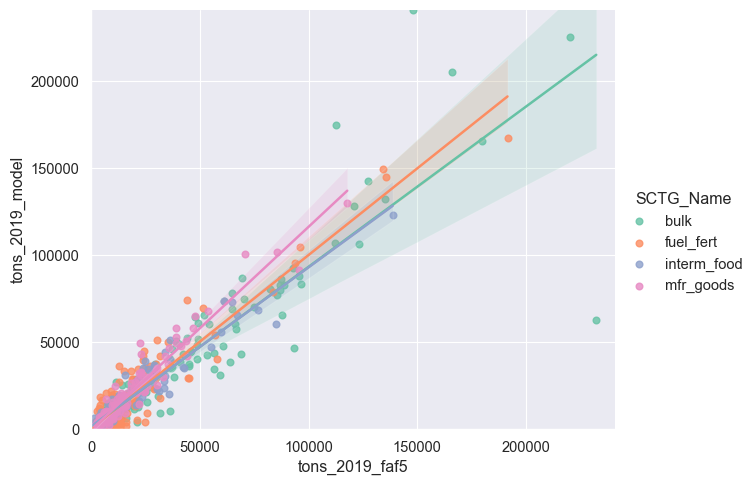

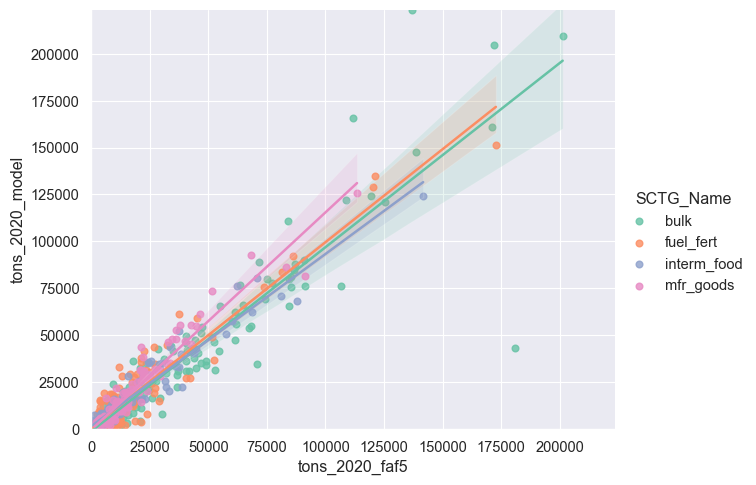

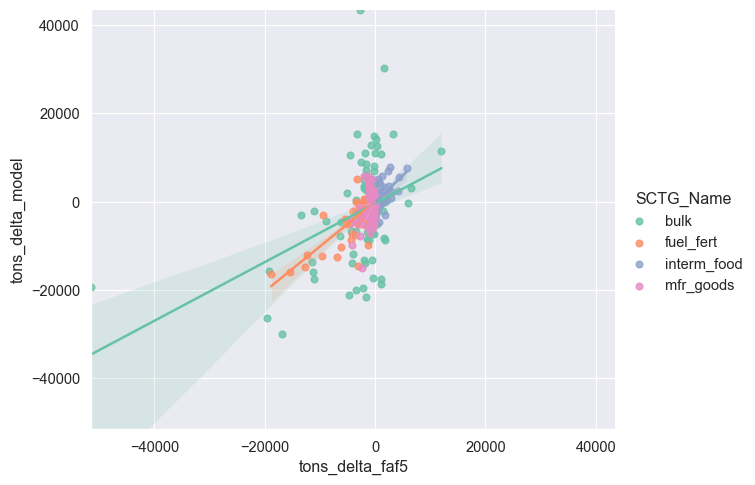

In [30]:
# scatter plot
production_comparison_to_plot = \
production_comparison.loc[production_comparison['SCTG_Name'] != 'other']
sns.set_context("paper", font_scale=1.2)
upper_bound = max(production_comparison_to_plot['tons_2019_faf5'].max(), 
                 production_comparison_to_plot['tons_2019_model'].max())
sns.lmplot(data = production_comparison_to_plot, x="tons_2019_faf5", y="tons_2019_model", hue="SCTG_Name",
          height=5, aspect=1.3, palette = 'Set2')
plt.xlim([0, upper_bound])
plt.ylim([0, upper_bound])
plt.show()


upper_bound = max(production_comparison_to_plot['tons_2020_faf5'].max(), 
                 production_comparison_to_plot['tons_2020_model'].max())
sns.lmplot(data=production_comparison_to_plot, x="tons_2020_faf5", y="tons_2020_model", hue="SCTG_Name",
          height=5, aspect=1.3, palette = 'Set2')
plt.xlim([0, upper_bound])
plt.ylim([0, upper_bound])
plt.show()


upper_bound = max(production_comparison_to_plot['tons_delta_faf5'].max(), 
                 production_comparison_to_plot['tons_delta_model'].max())
lower_bound = min(production_comparison_to_plot['tons_delta_faf5'].min(), 
                 production_comparison_to_plot['tons_delta_model'].min())
sns.lmplot(data = production_comparison_to_plot, x="tons_delta_faf5", y="tons_delta_model", hue="SCTG_Name",
          height=5, aspect=1.3, palette = 'Set2')
plt.xlim([lower_bound, upper_bound])
plt.ylim([lower_bound, upper_bound])
plt.show()

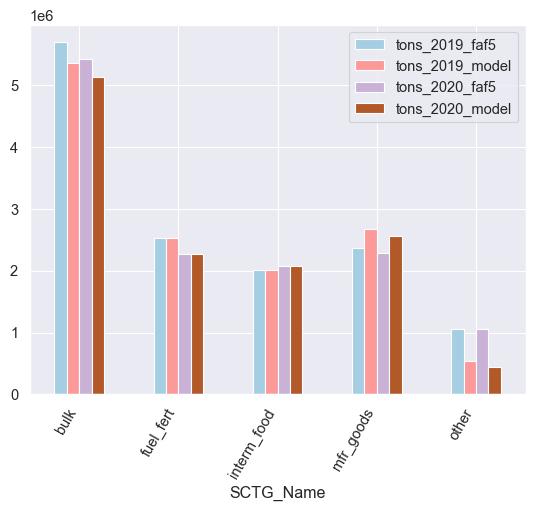

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'bulk'),
  Text(1, 0, 'fuel_fert'),
  Text(2, 0, 'interm_food'),
  Text(3, 0, 'mfr_goods'),
  Text(4, 0, 'other')])

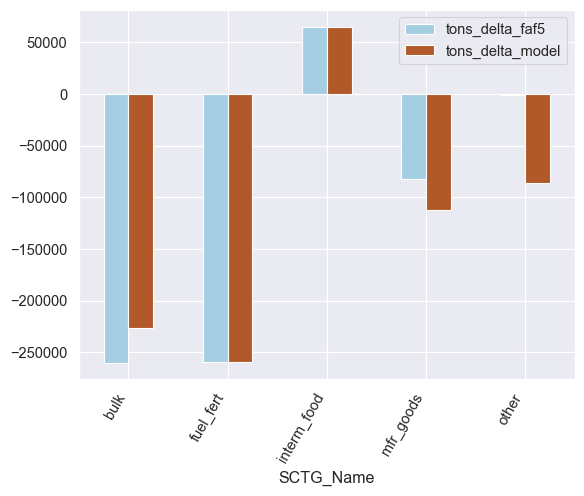

In [28]:
# create bar plot
col_to_sum = ['tons_2019_faf5', 'tons_2019_model', 'tons_2020_faf5', 'tons_2020_model']
production_comparison_agg = production_comparison.groupby('SCTG_Name')[col_to_sum].sum()

production_comparison_agg.plot(kind = 'bar', colormap = 'Paired')
plt.xticks(rotation = 60, ha = 'right')

plt.show()

col_to_sum = ['tons_delta_faf5', 'tons_delta_model']
production_comparison_agg = production_comparison.groupby('SCTG_Name')[col_to_sum].sum()

production_comparison_agg.plot(kind = 'bar', colormap = 'Paired')
plt.xticks(rotation = 60, ha = 'right')

In [5]:
# process faf data for validation
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
# faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == 1] #select domestic shipment only
print('total domestic load (1000 tons)')
print(faf_data_domestic.loc[:, shipment_load_attr].sum())
faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['mode_def'] != 'Other']
print('total domestic load from eligible modes (1000 tons)')
print(faf_data_domestic.loc[:, shipment_load_attr].sum())
faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] != 'other']
# bay_area_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(c.region_code)]
# bay_area_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(c.region_code)]
print('total domestic load from eligible modes+commodity (1000 tons)')
print(faf_data_domestic[shipment_load_attr].sum())
faf_data_domestic.head(5)

total domestic load (1000 tons)
17477578.946597006
total domestic load from eligible modes (1000 tons)
13588498.703573994
total domestic load from eligible modes+commodity (1000 tons)
12534601.670188995


,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,6.342501,7.763605,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live),62.055473
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,82.113979,96.869428,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live),124.036282
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.564126,0.638719,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live),325.379820
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.155784,3.394250,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live),171.439975
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.969298,2.141527,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live),244.231728


In [6]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
# modeled_bay_area_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
# modeled_bay_area_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
print(modeled_data.ShipmentLoad.sum())
modeled_data.head(5)

11501079.57701564


,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,Commodity_SCTG,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11,Birmingham,11,Birmingham,3,3,interm_food,For-hire Truck,0.0,4.121139,203,1,1,0.0
1,1,11,Birmingham,11,Birmingham,3,3,interm_food,Private Truck,0.0,5.002552,257,1,1,0.0
2,2,11,Birmingham,11,Birmingham,3,3,interm_food,Rail/IMX,0.0,0.043508,2,1,1,0.0
3,3,11,Birmingham,11,Birmingham,4,3,interm_food,For-hire Truck,0.0,63.615312,2515,1,1,0.0
4,4,11,Birmingham,11,Birmingham,4,3,interm_food,Private Truck,0.0,49.071464,1940,1,1,0.0


interm_food


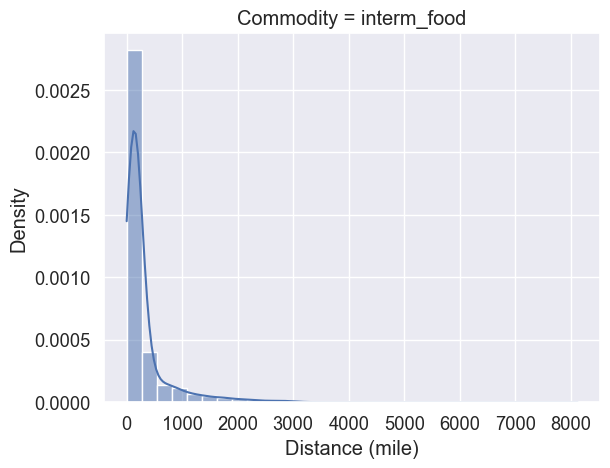

bulk


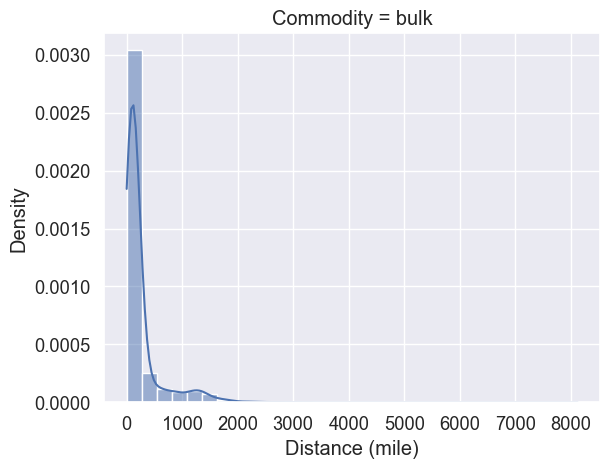

mfr_goods


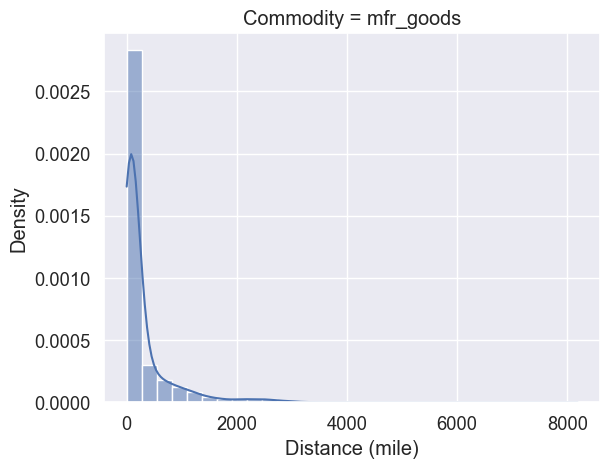

fuel_fert


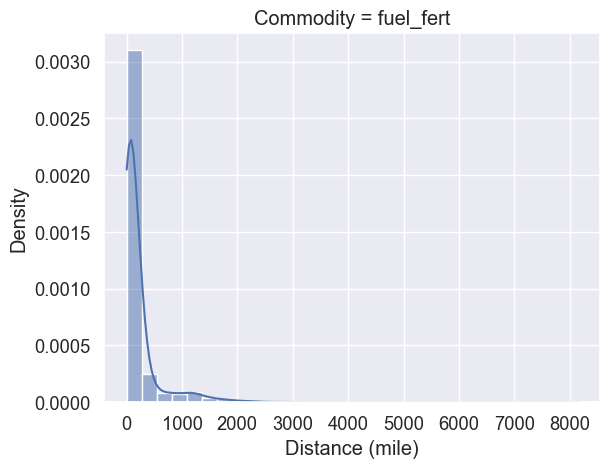

other


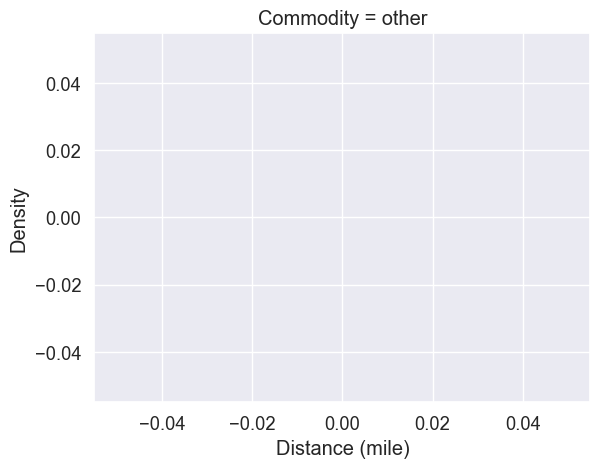

In [7]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck
5291.7


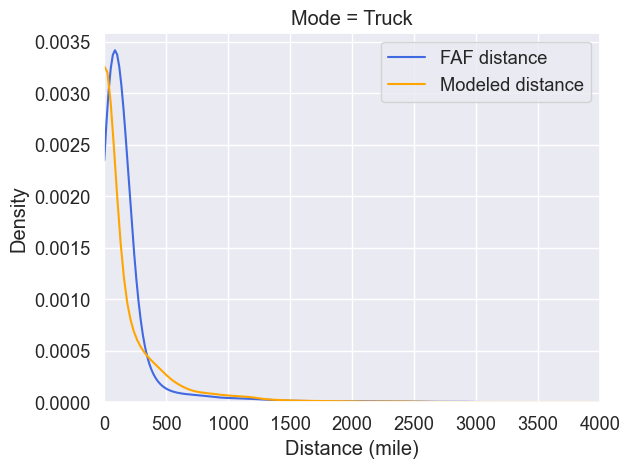

Rail
4967.27921


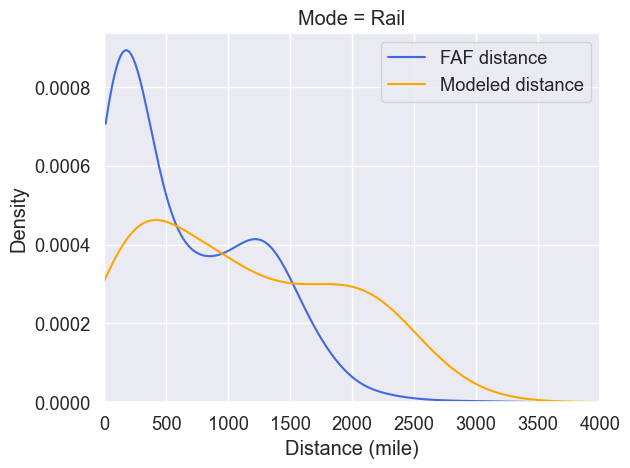

Air
4774.079663


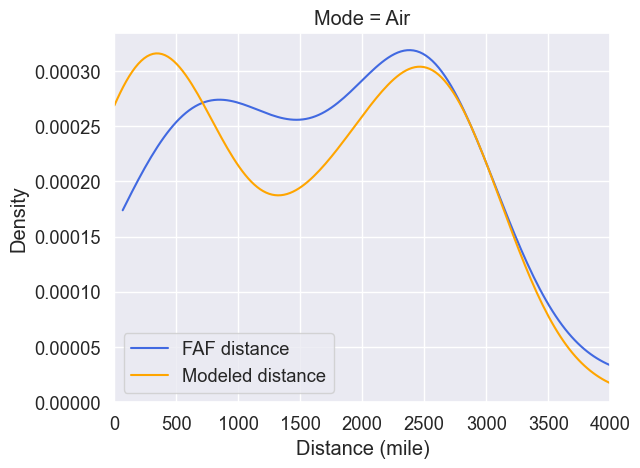

Parcel
3202.717189


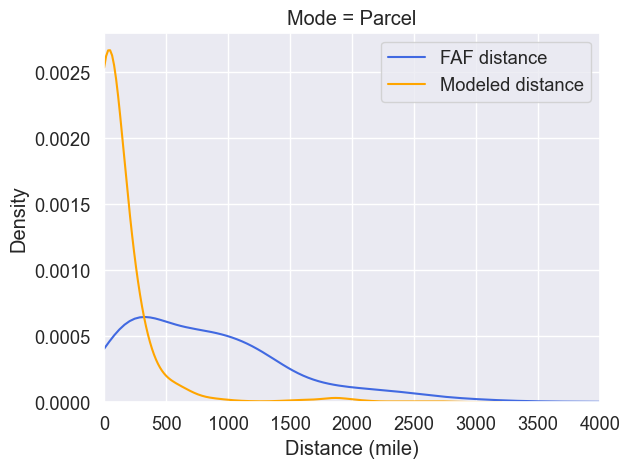

In [8]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}

mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_data.loc[modeled_data['mode_choice'].isin(mode_to_select)]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
                                 'Distance', 'ShipmentLoad', 'tmiles')
    print(max_distance)
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')     
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 4000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_outflow_distance_statistics_by_mode.csv')

# attraction
# for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
#     print(mode)
#     mode_to_select = FAF_mode_mapping[mode]
#     modeled_data_to_describe = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['mode_choice'].isin(mode_to_select)]
# #     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
# #     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
# #                                  'Distance', 'ShipmentLoad', 'tmiles')
# #     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
#     faf_data_to_describe = bay_area_inflow.loc[bay_area_inflow['mode_def'] == mode]
#     sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
#              color = 'royalblue')  
#     sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
#              color = 'orange')
#     plt.xlim([0, 6000])
#     plt.legend(['FAF distance', 'Modeled distance'])
#     plt.title('Mode = ' + mode)
#     plt.xlabel('Distance (mile)')
#     plt.ylabel('Density')
#     plt.savefig('plots_national' + '/inflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
#     plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

In [10]:
modeled_data = modeled_data.sort_values(by='Distance', ascending = False)
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,Commodity_SCTG,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
182476,182476,519,Rest of VA,532,Portland (WA),33,4,mfr_goods,For-hire Truck,6.020263e+05,0.108116,110,1,1,5568.350000
101071,101071,329,Rest of NV,519,Rest of VA,33,4,mfr_goods,For-hire Truck,2.625325e+06,0.490785,498,1,1,5349.240000
181312,181312,519,Rest of VA,329,Rest of NV,34,4,mfr_goods,For-hire Truck,1.512671e+05,0.028278,122,1,1,5349.240000
181309,181309,519,Rest of VA,329,Rest of NV,24,4,mfr_goods,For-hire Truck,6.124230e+06,1.144879,403,1,1,5349.240000
70213,70213,230,Maine,151,Honolulu,30,4,mfr_goods,Parcel,7.681131e+05,0.144940,1193,1,1,5299.511945


FAF shipment        1.253460e+07
Modeled shipment    1.150108e+07
dtype: float64
FAF tonmile        3.101380e+06
Modeled tonmile    3.346881e+06
dtype: float64


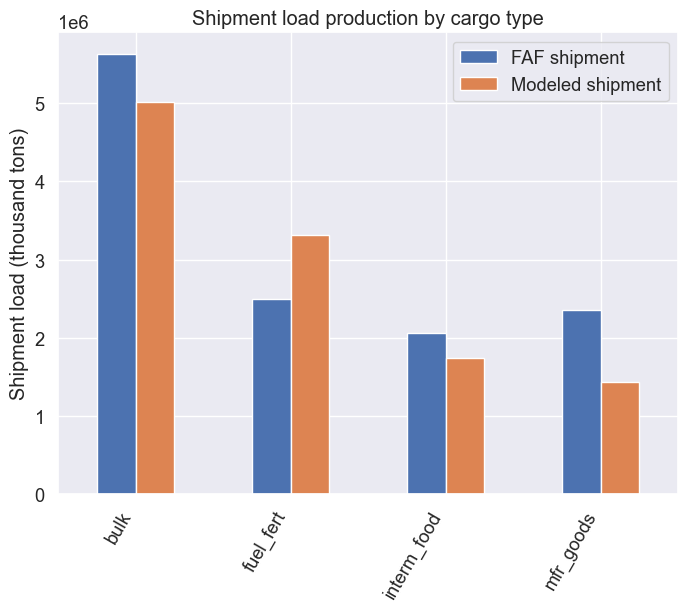

In [9]:
### plot shipment generation by commodity group
# data aggregation
modeled_data = modeled_data.loc[modeled_data['SCTG_Name'] != 'other']
FAF_shipment_by_sctg = faf_data_domestic.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_data.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()

shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']
print(shipment_generation_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_generation_by_sctg.plot(y = ['FAF shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xticks(rotation = 60, ha = 'right')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'shipment_comparison_by_sctg.png', bbox_inches='tight', dpi = 300)
plt.show()


# shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
#                                  figsize = (8, 6), kind = 'bar',  
#                                  title = 'Shipment tonmile production by cargo type')
# plt.xlabel('')
# plt.ylabel('Shipment tonmile')
# plt.legend(loc=1)
# plt.savefig('plots_national/' + 'outflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
# plt.show()

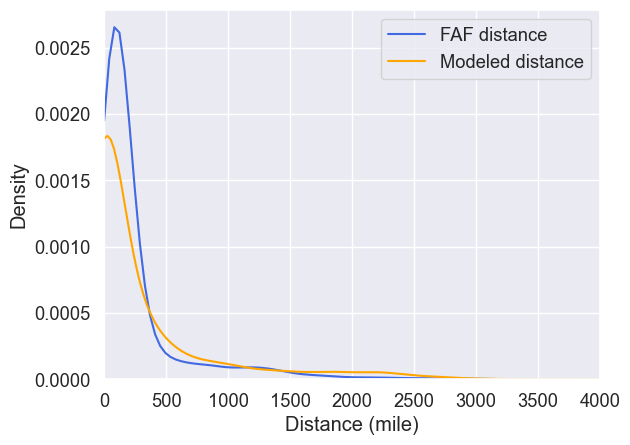

In [10]:
# KDE plot
sns.kdeplot(data = faf_data_domestic, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_data, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 4000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.savefig(plot_dir + 'distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()


# sns.kdeplot(data = bay_area_inflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
#              color = 'royalblue')  
# sns.kdeplot(data = modeled_bay_area_inflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
#              color = 'orange')
# plt.xlim([0, 6000])
# plt.legend(['FAF distance', 'Modeled distance'])
# plt.xlabel('Distance (mile)')
# plt.ylabel('Density')
# plt.savefig('Plot_aus_' + str(analysis_year) + '/inflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
# plt.show()

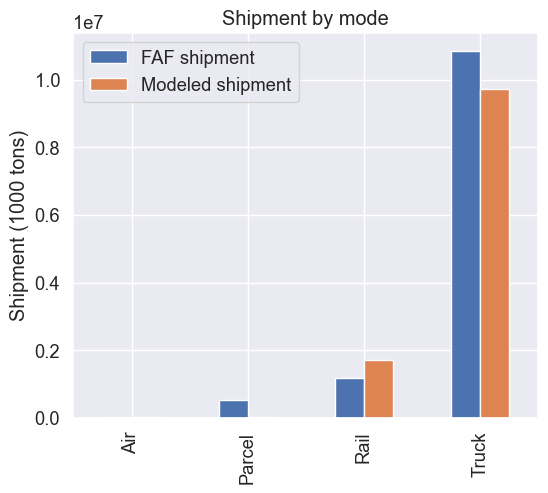

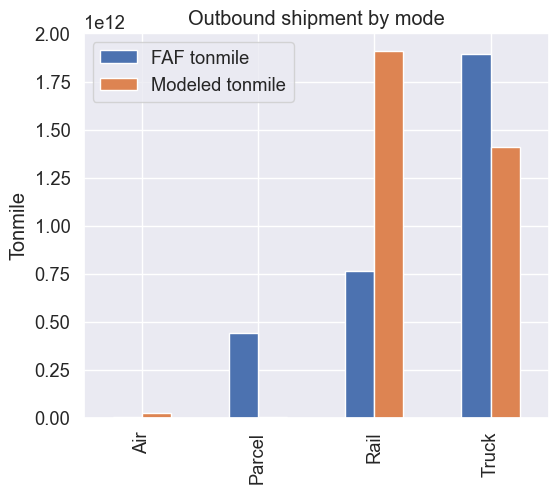

In [11]:
# plot shipment production by mode choice
model_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
modeled_data.loc[:, 'mode_def'] = modeled_data.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_outflow_by_mode = faf_data_domestic.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()

agg_modeled_outflow_by_mode = modeled_data.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']
# compare_outflow_by_mode = \
# compare_outflow_by_mode.loc[compare_outflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig(plot_dir +  'shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig(plot_dir + 'tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(output_dir + 'outflow_shipment_by_mode_comparison.csv')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


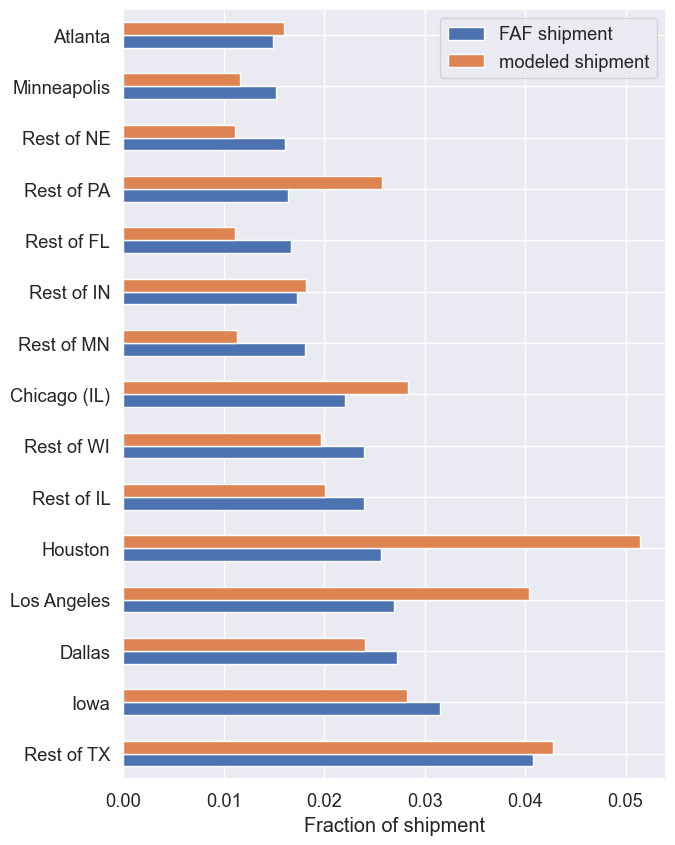

In [12]:
# plot outflow distance and tonnage distribution
nzones = 15
agg_faf_outflow_by_destination = faf_data_domestic.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_data.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')


compare_outflow_by_destination = \
compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})
compare_outflow_by_destination.loc[:, 'FAF shipment'] = \
compare_outflow_by_destination.loc[:, 'FAF shipment'] / compare_outflow_by_destination.loc[:, 'FAF shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled shipment'] = \
compare_outflow_by_destination.loc[:, 'modeled shipment'] / compare_outflow_by_destination.loc[:, 'modeled shipment'].sum()

# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment')
plt.ylabel('')
plt.savefig(plot_dir + 'percent_outflow_load_comparison.png', bbox_inches = 'tight', dpi = 200)
plt.show()


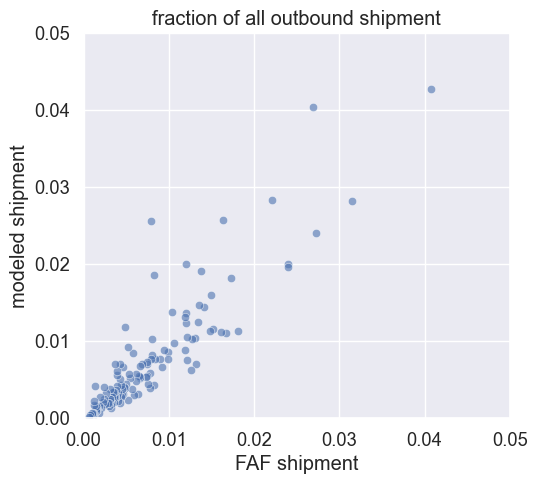

In [13]:
plt.figure(figsize = (5.5,5))
sns.scatterplot(data = compare_outflow_by_destination, 
                x="FAF shipment", 
                y="modeled shipment", alpha = 0.6)
plt.xlim([0,0.05])
plt.ylim([0,0.05])
plt.title('fraction of all outbound shipment')
plt.savefig(plot_dir + 'percent_outflow_load_paired.png', bbox_inches = 'tight', dpi = 200)
plt.show()

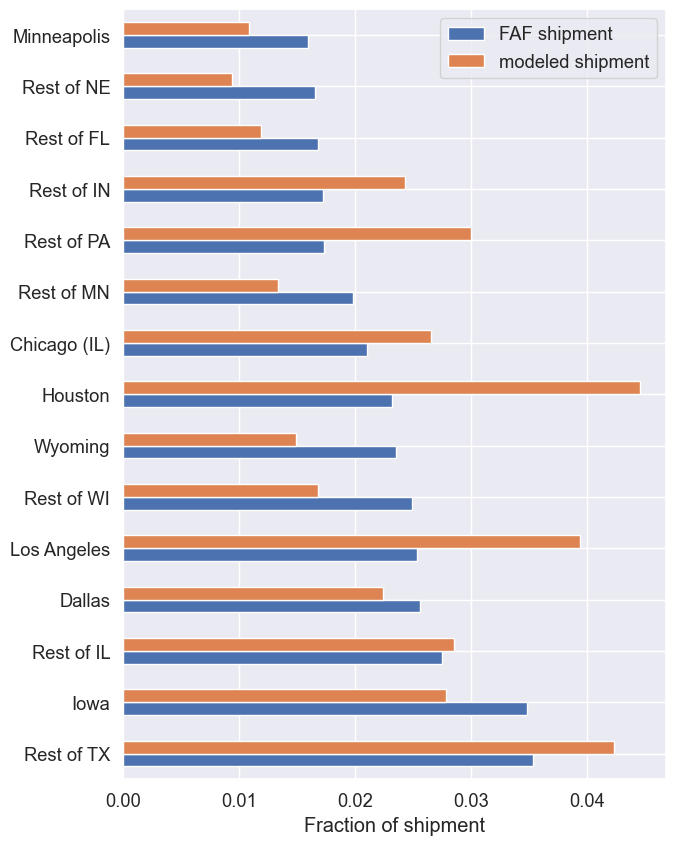

In [14]:
# plot inflow distance and tonnage distribution
nzones = 15
agg_faf_inflow_by_origin = faf_data_domestic.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_data.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')



compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})


compare_inflow_by_origin.loc[:, 'FAF shipment'] = compare_inflow_by_origin.loc[:, 'FAF shipment'] / compare_inflow_by_origin.loc[:, 'FAF shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled shipment'] = compare_inflow_by_origin.loc[:, 'modeled shipment'] / compare_inflow_by_origin.loc[:, 'modeled shipment'].sum()

# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment')
plt.ylabel('')
plt.savefig(plot_dir  + 'percent_inflow_load_comparison.png', bbox_inches = 'tight', dpi = 200)
plt.show()


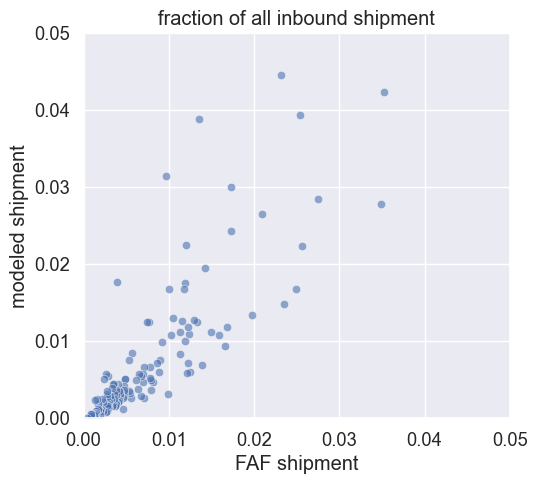

In [15]:
plt.figure(figsize = (5.5,5))
sns.scatterplot(data = compare_inflow_by_origin, 
                x="FAF shipment", 
                y="modeled shipment", alpha = 0.6)
plt.xlim([0,0.05])
plt.ylim([0,0.05])
plt.title('fraction of all inbound shipment')
plt.savefig(plot_dir + 'percent_inflow_load_paired.png', bbox_inches = 'tight', dpi = 200)
plt.show()